In [1]:
import sys
sys.path.append('..')

In [2]:
from data import dataset, generate_data
from models import RSSM, MultiRSSM, VCD, adaptation_model
import json
from jax import random
from jax import numpy as jnp
from matplotlib import pyplot as plt
from experiments import evaluation, adaptation

In [3]:
# set the number of episodes for adaptation
transfer_data_size = 4

In [4]:
data_conf = json.load(open('../data/mixed_state_adapt_conf.json'))
train_data_config = data_conf['train_data_conf']
mixing_matrix = random.normal(random.PRNGKey(0), (8, 12))
mixing_function = lambda x: x @ mixing_matrix


train_data = dataset.DataLoader(
    generate_data.get_states,
    train_data_config,
    transfer_data_size,
    data_conf["train_data_seed"],
    mixing_function,
)

test_data_config = data_conf['test_data_conf']
test_data = dataset.DataLoader(
    generate_data.get_states,
    test_data_config,
    1000,
    data_conf["train_data_seed"],
    mixing_function,
)


In [ ]:
rssm_path = '../pretrain/mixed_state_rssm'
rssm_chkpt_id = 0
rssm_error, rssm_adapt_state = adaptation.adapt(train_data, test_data, adaptation_model.AdaptRSSM, RSSM.RSSM, rssm_path, rssm_chkpt_id, mixing_matrix)

vcd_path = '../pretrain/mixed_state_vcd'
vcd_chkpt_id = 0
vcd_error, rssm_adapt_state = adaptation.adapt(train_data, test_data, adaptation_model.AdaptVCD, VCD.VCD, vcd_path, vcd_chkpt_id, mixing_matrix)

: 

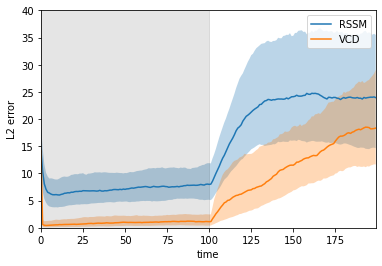

In [12]:
plt.plot(jnp.median(rssm_error, axis=1), label='RSSM')
plt.fill_between(jnp.arange(200), jnp.quantile(rssm_error, 0.75, axis=1), jnp.quantile(rssm_error, 0.25, axis=1), alpha=0.3)
plt.plot(jnp.median(vcd_error, axis=1), label='VCD')
plt.fill_between(jnp.arange(200), jnp.quantile(vcd_error, 0.75, axis=1), jnp.quantile(vcd_error, 0.25, axis=1), alpha=0.3)

plt.fill_betweenx([0,40], [0,0], [100,100], color='k', alpha=0.1)
plt.ylim([0, 40])
plt.xlim([0,199])
plt.xlabel('time')
plt.ylabel('L2 error')
plt.legend()

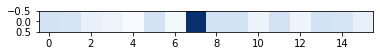

In [11]:
# show identified intervention targets.
plt.imshow(rssm_adapt_state.params['params']['intervention_targets'], cmap='Blues')